# Excercises - Word2Vec Simpsons

## Import Libraries

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import defaultdict
import spacy
import logging
import multiprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
!python3 -m spacy download en_core_web_sm 
import en_core_web_sm

%matplotlib inline
sns.set_style("darkgrid")

Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Data Import

In [4]:
# Data can be found at https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset
df_raw = pd.read_csv('./simpsons_script_lines.csv')
df_raw.head()

/var/folders/dv/t9jbtc_n21l7bcwt03cw661h0000gn/T/ipykernel_1034/1242424279.py:2: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('./simpsons_script_lines.csv')


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33


## Data Preparation

In [5]:
df=pd.DataFrame(columns=['raw_character_text', 'spoken_words'])

raw_character_text = []
spoken_words = []

for s in df_raw['raw_text']:
  spl = s.split(':')
  char = spl[0]
  if len(spl)>2:
    words = ''
    for j in spl[1:]:
      words = words + j
  else:
    words = spl[1]
  raw_character_text.append(char)
  spoken_words.append(words)

df['raw_character_text'] = raw_character_text
df['spoken_words'] = spoken_words
del raw_character_text
del spoken_words
del df_raw
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Someti..."
1,Lisa Simpson,(NEAR TEARS) Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk ...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end...


In [6]:
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Data Cleaning

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed     # doc needs to be a spacy Doc object

def cleaning(doc):
    # Lemmatizes and removes stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [9]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.32 mins


In [10]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(125276, 1)

## Create Bigrams

In [11]:
sent = [row.split() for row in df_clean['clean']]

In [12]:
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
# Phraser() cuts down memory consumption of Phrases()

INFO - 16:15:19: collecting all words and their counts
INFO - 16:15:19: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:15:19: PROGRESS: at sentence #10000, processed 56269 words and 45106 word types
INFO - 16:15:19: PROGRESS: at sentence #20000, processed 114309 words and 84166 word types
INFO - 16:15:19: PROGRESS: at sentence #30000, processed 176108 words and 123596 word types
INFO - 16:15:19: PROGRESS: at sentence #40000, processed 233800 words and 156944 word types
INFO - 16:15:19: PROGRESS: at sentence #50000, processed 289581 words and 188733 word types
INFO - 16:15:19: PROGRESS: at sentence #60000, processed 341494 words and 216872 word types
INFO - 16:15:19: PROGRESS: at sentence #70000, processed 397241 words and 246804 word types
INFO - 16:15:19: PROGRESS: at sentence #80000, processed 455021 words and 277255 word types
INFO - 16:15:19: PROGRESS: at sentence #90000, processed 512089 words and 306811 word types
INFO - 16:15:19: PROGRESS: at sentence #10

In [13]:
sentences = bigram[sent] # Transform the corpus based on the bigrams detected

## Show Most Frequent Words

In [14]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'int', 'ext', 'look', 'day', 'think', 'homer']

## Model Training

In [15]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [16]:
w2v_model = Word2Vec(min_count=20, window=2, vector_size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

INFO - 16:15:20: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2024-03-28T16:15:20.643801', 'gensim': '4.3.2', 'python': '3.9.6 (default, Feb  3 2024, 15:58:27) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'created'}


In [17]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
## Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them)

INFO - 16:15:20: collecting all words and their counts
INFO - 16:15:20: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:15:20: PROGRESS: at sentence #10000, processed 54249 words, keeping 8521 word types
INFO - 16:15:20: PROGRESS: at sentence #20000, processed 110246 words, keeping 12772 word types
INFO - 16:15:20: PROGRESS: at sentence #30000, processed 169960 words, keeping 16313 word types
INFO - 16:15:20: PROGRESS: at sentence #40000, processed 225841 words, keeping 18614 word types
INFO - 16:15:20: PROGRESS: at sentence #50000, processed 280037 words, keeping 20806 word types
INFO - 16:15:20: PROGRESS: at sentence #60000, processed 330392 words, keeping 22632 word types
INFO - 16:15:20: PROGRESS: at sentence #70000, processed 384483 words, keeping 24437 word types
INFO - 16:15:20: PROGRESS: at sentence #80000, processed 440463 words, keeping 26231 word types
INFO - 16:15:20: PROGRESS: at sentence #90000, processed 495771 words, keeping 27781 word types


Time to build vocab: 0.01 mins


In [18]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:15:21: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 4217 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2024-03-28T16:15:21.093757', 'gensim': '4.3.2', 'python': '3.9.6 (default, Feb  3 2024, 15:58:27) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'train'}
INFO - 16:15:21: EPOCH 0: training on 693458 raw words (293489 effective words) took 0.7s, 409538 effective words/s
INFO - 16:15:22: EPOCH 1: training on 693458 raw words (293344 effective words) took 0.7s, 410640 effective words/s
INFO - 16:15:23: EPOCH 2: training on 693458 raw words (293708 effective words) took 0.7s, 410899 effective words/s
INFO - 16:15:23: EPOCH 3: training on 693458 raw words (293400 effective words) took 0.7s, 412109 effective words/s
INFO - 16:15:24: EPOCH 4: training on 693458 raw words (293781 effective words) took 0.7s, 411101 effective words/s
INFO - 16:15:25: EP

Time to train the model: 0.35 mins


In [19]:
w2v_model.init_sims(replace=True)

/var/folders/dv/t9jbtc_n21l7bcwt03cw661h0000gn/T/ipykernel_1034/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 16:15:42: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


## Model Exploration

In [20]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.6196138262748718),
 ('homie', 0.4911471903324127),
 ('mr_burn', 0.4856871962547302),
 ('pointedly', 0.47956782579421997),
 ('coldly', 0.46308743953704834),
 ('jessica', 0.46121588349342346),
 ('moustache', 0.45958971977233887),
 ('patty_selma', 0.4586116075515747),
 ('smoothly', 0.4563136398792267),
 ('dad', 0.45623978972435)]

In [21]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('honor', 0.5536956787109375),
 ('fellow', 0.5455259084701538),
 ('montgomery_burn', 0.5314340591430664),
 ('request', 0.5304556488990784),
 ('versus', 0.5224557518959045),
 ('client', 0.5213972926139832),
 ('waylon', 0.5212583541870117),
 ('host', 0.5105577707290649),
 ('kidnap', 0.5087609887123108),
 ('contestant', 0.5082157850265503)]

In [22]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.7881053686141968),
 ('jessica', 0.5766091346740723),
 ('allison', 0.5709821581840515),
 ('milhouse', 0.558189868927002),
 ('maggie', 0.5231336355209351),
 ('jealous', 0.5212194919586182),
 ('babysitter', 0.520566999912262),
 ('pay_attention', 0.5192984342575073),
 ('classroom', 0.5137593746185303),
 ('janey', 0.51101154088974)]

In [23]:
w2v_model.wv.similarity('maggie', 'baby')

0.59999293

In [24]:
w2v_model.wv.similarity('bart', 'nelson')

0.35039073

In [25]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

'milhouse'

In [26]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [27]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [28]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('man', 0.43574726581573486),
 ('married', 0.4023003578186035),
 ('kind', 0.4016050398349762)]

In [29]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.5906951427459717),
 ('jessica', 0.49065423011779785),
 ('jealous', 0.47052687406539917)]

In [34]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 19 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    ext = 50
    plt.xlim(Y[:, 0].min()-ext, Y[:, 0].max()+ext)
    plt.ylim(Y[:, 1].min()-ext, Y[:, 1].max()+ext)

    plt.title('t-SNE visualization for {}'.format(word.title()))

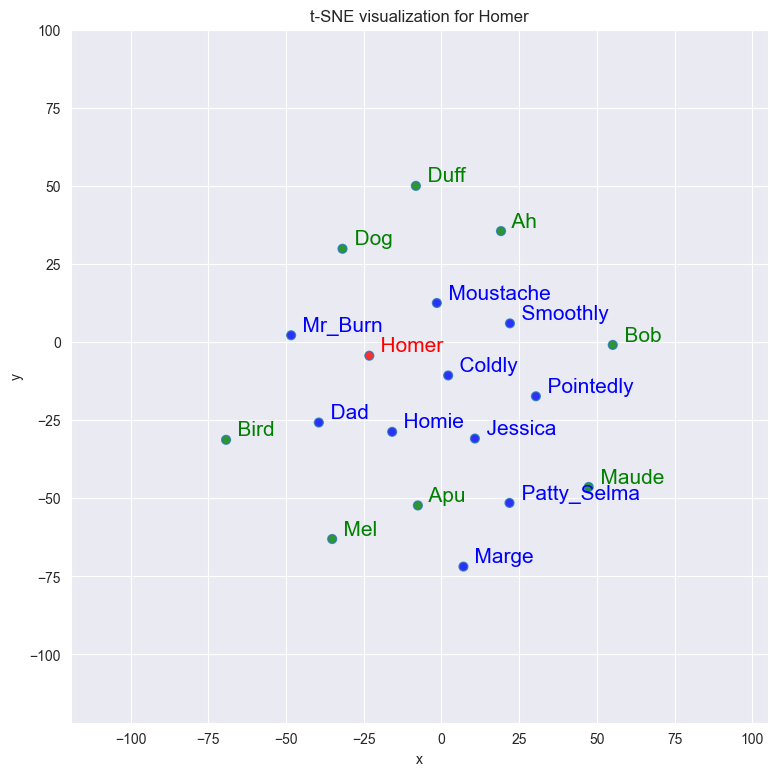

In [35]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

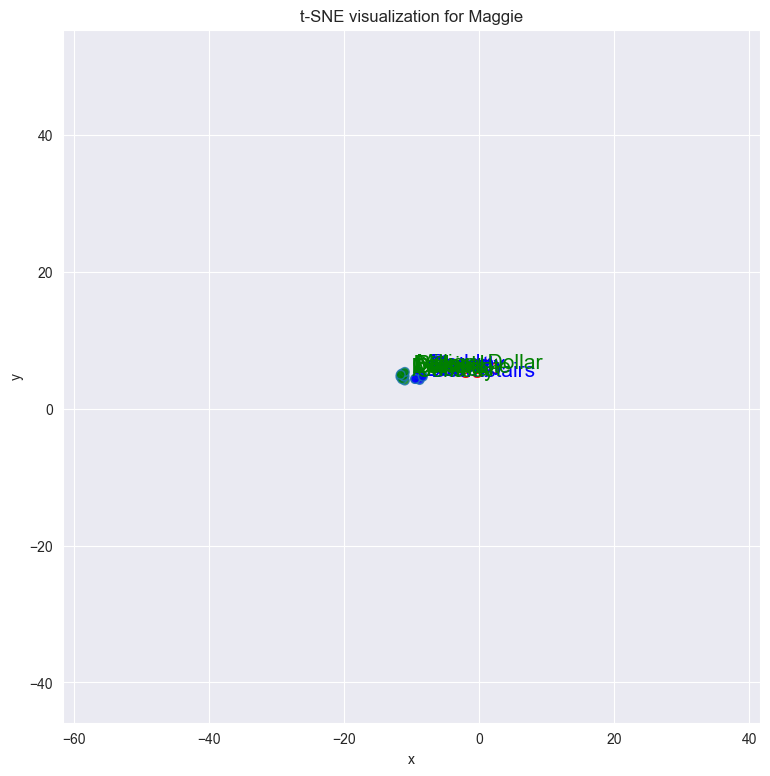

In [36]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

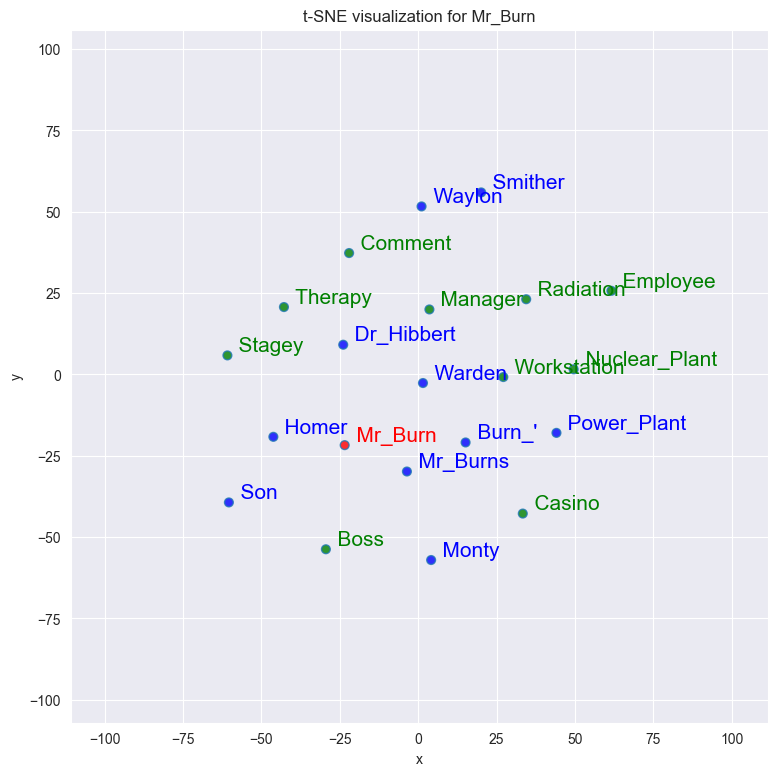

In [37]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])